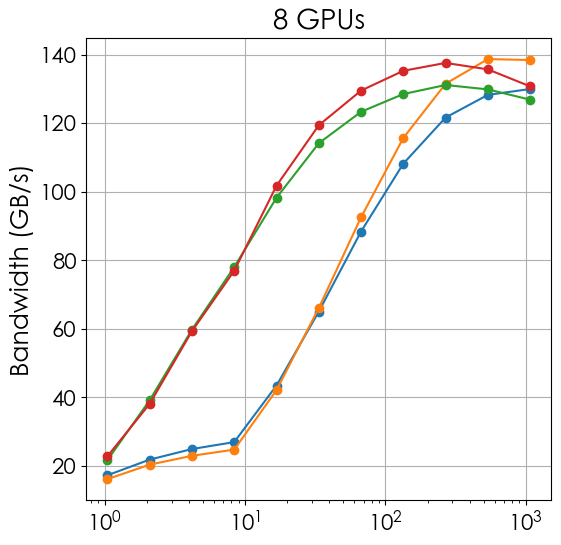

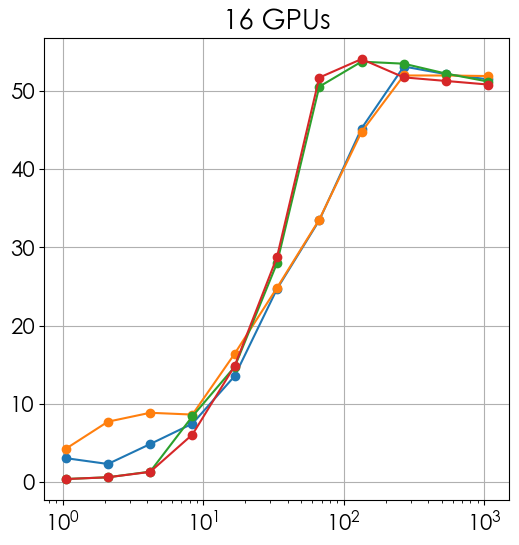

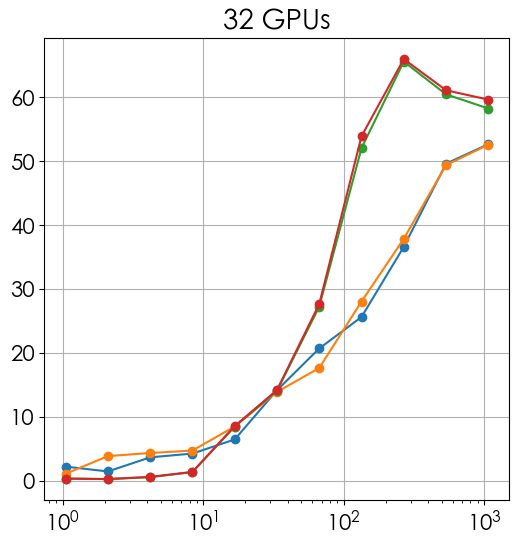

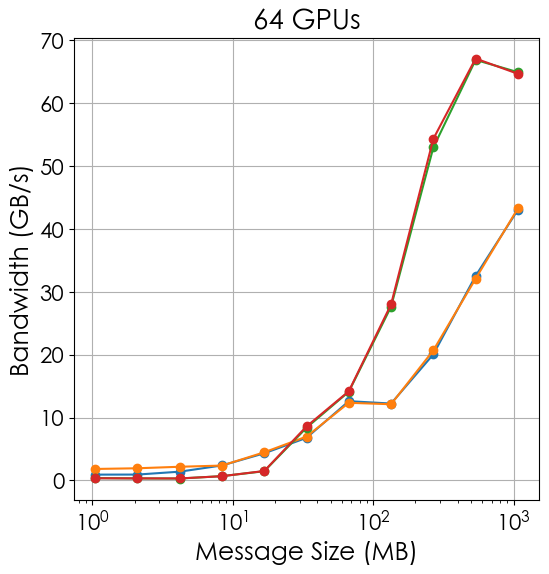

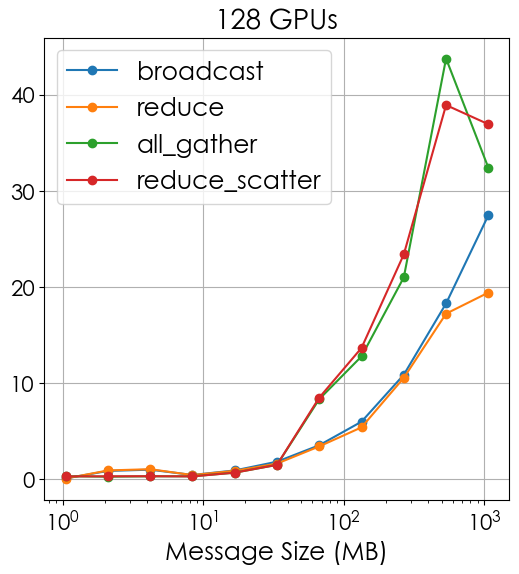

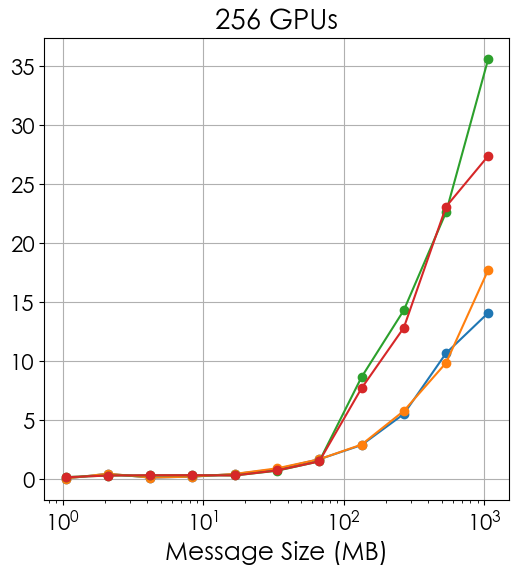

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
plt.rcParams["font.family"] = "Century Gothic"
%matplotlib inline


log_dir = "./data/rccl/set-envs"  
pattern = re.compile(r"log\.Tree\.(?P<op>\w+)\.n(?P<nodes>\d+)\..*")
data_dict = {}


log_pattern = os.path.join(log_dir, "log.Tree.*.n*..*")


for filename in glob.glob(log_pattern):
    match = pattern.search(os.path.basename(filename))
    if not match:
        continue  
    op = match.group("op")
    nodes = int(match.group("nodes"))

    df = pd.read_csv(
        filename,
        comment="#",
        delim_whitespace=True,
        header=None,
        names=["size", "count", "type", "redop", "root",
               "time_out", "algbw_out", "busbw_out", "wrong_out",
               "time_in", "algbw_in", "busbw_in", "wrong_in"]
    )
    
    data_dict[(nodes, op)] = df

node_counts = sorted({nodes for (nodes, _) in data_dict.keys()})


for nodes in node_counts:

    plt.figure(figsize=(6, 6))
    for op in ["broadcast", "reduce", "all_gather", "reduce_scatter"]:
        key = (nodes, op)
        if key in data_dict:
            df = data_dict[key]
            df = df.sort_values("size")
            plt.plot(df["size"]/1e6, df["busbw_out"], marker="o", label=op)
    
    if nodes > 4:         
        plt.xlabel("Message Size (MB)", fontsize=18)
    if nodes == 1 or nodes == 8: 
        plt.ylabel("Bandwidth (GB/s)", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xscale("log")  
    plt.title(f"{nodes*8} GPUs", fontsize=20)
    if nodes == 16:
        plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig(f"rccl-{nodes}.png", bbox_inches='tight')
    plt.show()


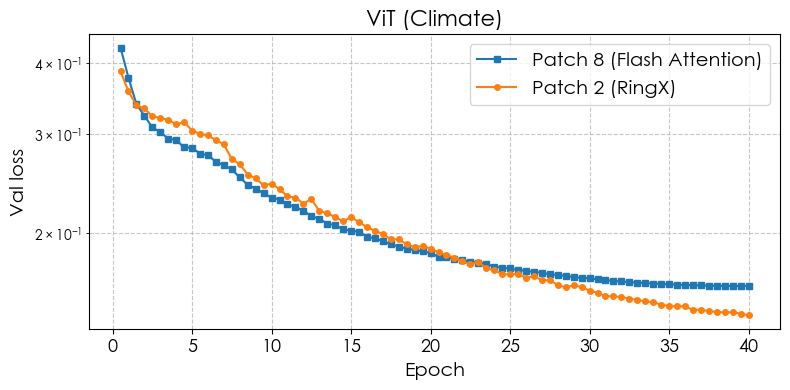

In [2]:
import re, numpy
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Century Gothic"
%matplotlib inline

def parse_log_file(filename):
    loss_values = []
    pattern = re.compile(r"Avg val loss=([0-9]*\.?[0-9]+)")
    
    with open(filename, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                loss = float(match.group(1))
                loss_values.append(loss)
                
    return loss_values


patch2_log = "data/vit/loss.patch2"
patch8_log = "data/vit/loss.patch8"

patch2_losses = parse_log_file(patch2_log)
patch8_losses = parse_log_file(patch8_log)


epochs_patch2 = range(1, len(patch2_losses) + 1)
epochs_patch8 = range(1, len(patch8_losses) + 1)


plt.figure(figsize=(8, 4))
plt.plot(numpy.array(epochs_patch8)/2, patch8_losses, label='Patch 8 (Flash Attention)', marker='s', markersize=4)
plt.plot(numpy.array(epochs_patch2)/2, patch2_losses, label='Patch 2 (RingX)', marker='o', markersize=4)


plt.title("ViT (Climate)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Val loss", fontsize=14)
plt.yscale('log')


plt.xticks(fontsize=13)
plt.yticks(fontsize=20)


plt.legend(fontsize=14)

plt.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("vit_loss.png", bbox_inches='tight')
plt.show()


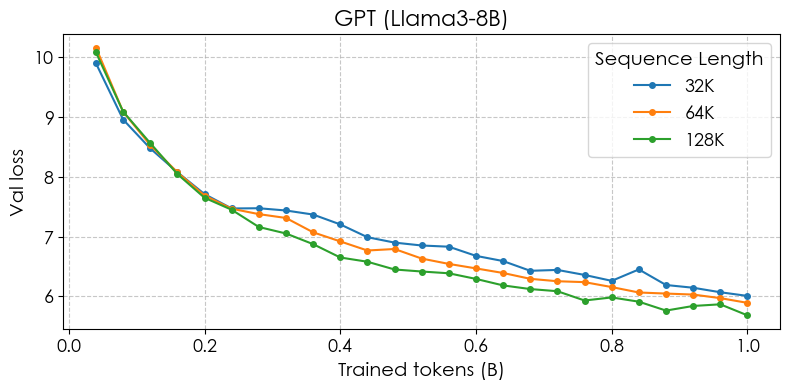

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('data/gpt/loss/wandb_export_2025-03-18T09_39_41.331-04_00.csv')


col1 = "32k-lamb-lr0.006 - validation/lm_loss"
col2 = "64k-lamb-lr0.006 - validation/lm_loss"
col3 = "128k-lamb-lr0.006 - validation/lm_loss"


tokens_millions = df["Step"] * 4/1000


plt.figure(figsize=(8, 4))
plt.plot(tokens_millions, df[col1], marker='o', markersize=4, label='32K')
plt.plot(tokens_millions, df[col2], marker='o', markersize=4, label='64K')
plt.plot(tokens_millions, df[col3], marker='o', markersize=4, label='128K')


plt.xlabel("Trained tokens (B)", fontsize=14)
plt.ylabel("Val loss", fontsize=14)
plt.title("GPT (Llama3-8B)", fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.legend(title="Sequence Length", prop={'size': 13}, title_fontsize=14)


plt.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("gpt_loss.png", bbox_inches='tight')

plt.show()

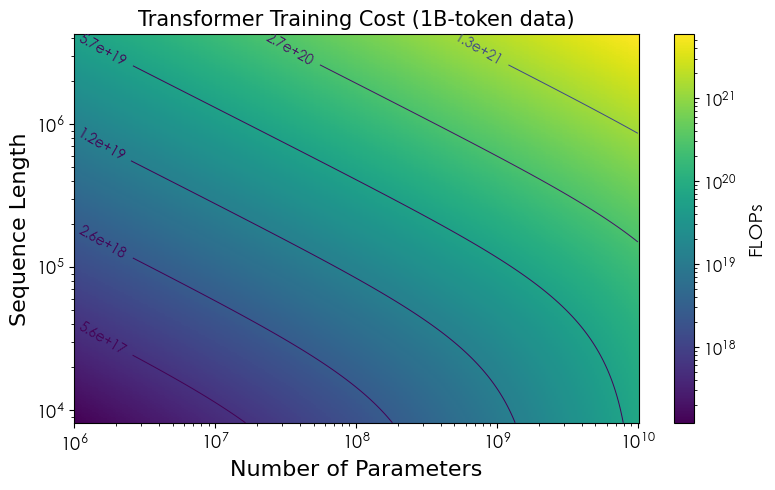

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
N_min, N_max = 1e6, 10e9      # 1 M → 10 B parameters
L_min, L_max = 8192, 4194304     # 8k → 4m tokens
n_points = 300               # grid resolution

N_vals = np.logspace(np.log10(N_min), np.log10(N_max), n_points)
L_vals = np.logspace(np.log10(L_min), np.log10(L_max), n_points)
N_grid, L_grid = np.meshgrid(N_vals, L_vals)


batch = 1
layer = 12
data  = 1e9#batch * L_grid
FLOPs = 6 * data * N_grid * (1 + L_grid / (6 * (N_grid / layer / 16) ** 0.5))


plt.figure(figsize=(8, 5))
heat = plt.pcolormesh(N_grid, L_grid, FLOPs, norm=LogNorm(), shading='auto')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Parameters', fontdict=font)
plt.ylabel('Sequence Length', fontdict=font)
plt.title('Transformer Training Cost (1B-token data)', fontdict=font, fontsize=15)


cbar = plt.colorbar(heat)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('FLOPs', fontsize=14, labelpad=8)


levels = np.logspace(np.log10(FLOPs.min()), np.log10(FLOPs.max()), num=8)
contours = plt.contour(N_grid, L_grid, FLOPs, levels=levels, linewidths=0.7)
plt.clabel(contours, inline=True, fontsize=10, fmt='%.1e')


markers = [

    #(5e6, 1e6, '5M params, 1M tokens'),
   # (1e9, 57e3, '1B params, 57K tokens'),   # (3)
]
for x, y, label in markers:
    plt.scatter(x, y, marker='o', s=80, label=label, color='orange')
    plt.text(x, y*1.2, label, ha='center', va='bottom', fontsize=10, color='white')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)    
#plt.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig("cost.png", bbox_inches='tight')
